In [1]:
import sys
sys.version

'3.6.8 (default, Jan 14 2019, 11:02:34) \n[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]'

# **Installation**

1. Import DeepMoon github repository and install the requirments: 

In [2]:
!git clone https://github.com/yuvalgrossman/DeepMoon
deepmoon_path='/content/DeepMoon/'
import sys
sys.path.append(deepmoon_path)
# print(sys.path)
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install -r /content/DeepMoon/requirements.txt
!apt-get -qq install python-cartopy python3-cartopy

# play a sound when done installing: 
import numpy as np
from IPython.display import Audio
framerate = 44100
t = np.linspace(0,5,framerate*2)
data = np.sin(2*np.pi*222*t)# + np.sin(2*np.pi*224*t)
Audio(data,rate=framerate, autoplay=True)

Cloning into 'DeepMoon'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 777 (delta 4), reused 0 (delta 0), pack-reused 768
Receiving objects: 100% (777/777), 23.18 MiB | 30.91 MiB/s, done.
Resolving deltas: 100% (494/494), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  libproj-dev proj-bin
0 upgraded, 2 newly installed, 0 to remove and 16 not upgraded.
Need to get 232 kB of archives.
After this operation, 1,220 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4.9.3-2 [199 kB]
Get:2 http://archive.ub

In [0]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image    # Requires Pillow
import urllib
import cartopy

Mounting google drive and download to it the data from Zenodo:

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
!mkdir gdrive/'My Drive'/DeepMoon
!mkdir gdrive/'My Drive'/DeepMoon/zenodo_downloads/
!ls --file-type 'gdrive/My Drive/DeepMoon/zenodo_downloads'
zenodo_path = 'gdrive/My Drive/DeepMoon/zenodo_downloads/'
# check if exist here and download data from Zenodo: 
Files = ["dev_craters.hdf5", # - Pandas HDFStore of crater locations and sizes for images in the validation dataset.
         "dev_images.hdf5", # - Input DEM images and output targets of the validation dataset.  Also includes each image's longitude/latitude bounds, and the pixel bounds of the global DEM regions cropped to make each image.
         "LunarLROLrocKaguya_118mperpix.png", # - LRO LOLA and Kaguya Terrain Camera DEM Merge, downsampled to 118 m/pixel and 8 bits/pixel.  The original file can be found at: https://astrogeology.usgs.gov/search/map/Moon/LRO/LOLA/Lunar_LRO_LrocKaguya_DEMmerge_60N60S_512ppd.
         "model_keras1.2.2.h5", # - Keras model weights for the DeepMoon CNN, compatible with Keras version 1.2.2.
         "model_keras2.h5", # - Keras model weights for the DeepMoon CNN, compatible with Keras versions >= 2.0.
         "post-processed_sample_images.zip", # - Contains a set of sample images from the test dataset with the Moon DEM image, new identified craters, CNN target predictions, and ground-truth. The new craters from these images were used to estimate the post-processed false positive rate. See Instructions.txt in .zip file for more details.
         "post-processed_test_craters.npy", # - numpy file containing post-processed craters identified by our pipeline on the test set. Each crater entry is arranged as a tuple: (longitude, latitude, radii), where longitude and latitude are in degrees, and radius is in kilometres. 
         "test_craters.hdf5", # - Pandas HDFStore of crater locations and sizes for images in the test dataset.
         "test_images.hdf5", # - Input DEM images and output targets of the test dataset.  Also includes each image's longitude/latitude bounds, and the pixel bounds of the global DEM regions cropped to make each image.
         "train_craters.hdf5", # - Pandas HDFStore of crater locations and sizes for images in the training dataset.
         "train_images.hdf5"] # - Input DEM images and output targets of the training dataset.  Also includes each image's longitude/latitude bounds, and the pixel bounds of the global DEM regions cropped to make each image.]
# del Files[-2:]
# del Files[:2]
for file in Files: 
  if os.path.isfile(zenodo_path+file): 
    print('File {} exist in library!'.format(file))
  else: 
    print('File {} does not exist in library. downloading now from Zenodo ...'.format(file))
    URL = "https://zenodo.org/record/1133969/files/"+file
#     urllib.urlretrieve(URL, zenodo_path+file)
    !wget -P "$zenodo_path" "$URL"
    print('Downloaded into {}'.format(zenodo_path+file))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
mkdir: cannot create directory ‘gdrive/My Drive/DeepMoon’: File exists
mkdir: cannot create directory ‘gdrive/My Drive/DeepMoon/zenodo_downloads/’: File exists
dev_craters.hdf5		   test_images.hdf5
dev_images.hdf5			   test_zenodo1_craters.hdf5
LunarLROLrocKaguya_118mperpix.png  test_zenodo1_images.hdf5
model_keras1.2.2.h5		   test_zenodo2_craters.hdf5
model_keras2.h5			   test_zenodo2_images.hdf5
post-processed_sample_images.zip   train_craters.hdf5
post-pro

# HDF5 Datasets

## Image Datasets

The training, validation and testing DEM images and target masks used to train and evaluate the DeepMoon model are found in `train_images.hdf5`, `dev_images.hdf5` and `test_images.hdf5`, respectively.  Also included in the files are each image's longitude/latitude bounds, which are used to post-process DeepMoon's crater detections.

These data can be read in using `h5py`.  Let's read in the `train_images.hdf5` data:

In [5]:
# train_imgs = h5py.File(zenodo_path + '/train_images.hdf5', 'r')
# for now lets only consider the test images: 
train_imgs = h5py.File(zenodo_path + '/train_images.hdf5', 'r')
print(type(train_imgs))

<class 'h5py._hl.files.File'>


Input images are 256 x 256 8-bit greyscale images, and target masks are 256 x 256 float arrays whose values fall between 0 and 1.  30000 inputs and targets are stored in the HDF5 file as two 30000 x 256 x 256 arrays; inputs can be found under the `'input_images'` entry, and targets under `'target_masks'`.  A target mask represents the ground truth crater locations of the input with the same image number (first array dimension).  Let's plot one input-target pair as an example (and set `vmin` and `vmax` to increase contrast of the input):

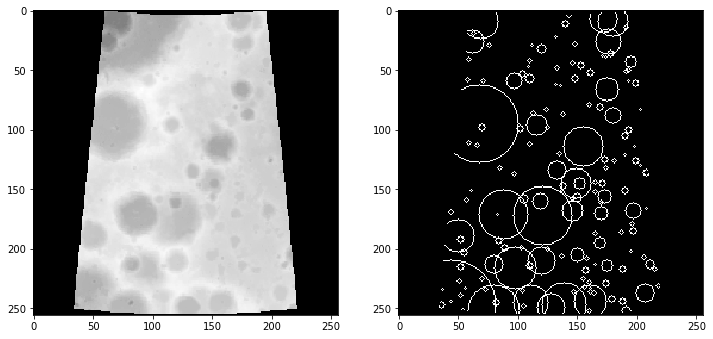

In [6]:
fig = plt.figure(figsize=[12, 6])
[ax1, ax2] = fig.subplots(1,2)
ax1.imshow(train_imgs['input_images'][100][...], origin='upper', cmap='Greys_r') #, vmin=50, vmax=150
ax2.imshow(train_imgs['target_masks'][100][...], origin='upper', cmap='Greys_r')
plt.show()

The longitude and latitude bounds of the input image can be found under `'longlat_bounds'`.  Here, instead of a 30000-element array, long/lat bounds are indexed by `'img_xxxxx'`, where xxxxx is the (zero-padded) image number, so the 4th image's boundaries are:

In [7]:
a=train_imgs['target_masks'][100][...]
a1 = a.reshape(a.shape[0]*a.shape[1],1)
np.unique(a1)
#print(a1.unique)
#plt.hist(a1[:],bins=1000)
#plt.show()
#print 

array([0., 1.], dtype=float32)

In [8]:
print(type(train_imgs))
print(train_imgs['longlat_bounds']['img_00100'][...])

<class 'h5py._hl.files.File'>
[-145.921875  -130.0703125   42.1328125   57.984375 ]


The definitions of these numbers is under the "definition" attribute for the entry:

In [9]:
train_imgs['longlat_bounds'].attrs['definition']

'(long min, long max, lat min, lat max) of the cropped image.'

Other entries in the HDF5 are to correct for image distortion during post-processing, or are unused in the current pipeline.  Each entry in the HDF5 has definition metadata under its `.attrs['definition']` attribute.

In [10]:
print(train_imgs['pix_bounds'].attrs['definition'])
x1,x2,y1,y2=train_imgs['pix_bounds']['img_00200'][...]

Pixel bounds of the Global DEM region that was cropped for the image.


In [11]:
print(list(train_imgs.keys()))
[print("{} : {}".format(x,train_imgs[x].attrs['definition'])) for x in list(train_imgs.keys())]
#train_imgs['input_images'].attrs['definition']

['cll_xy', 'input_images', 'longlat_bounds', 'pix_bounds', 'pix_distortion_coefficient', 'target_masks']
cll_xy : (x, y) pixel coordinates of the central long / lat.
input_images : Input image dataset.
longlat_bounds : (long min, long max, lat min, lat max) of the cropped image.
pix_bounds : Pixel bounds of the Global DEM region that was cropped for the image.
pix_distortion_coefficient : Distortion coefficient due to projection transformation.
target_masks : Target mask dataset.


[None, None, None, None, None, None]

In [25]:
# plot image frame in the global context: 
!mkdir DeepMoon/maps
# download albedo map: 
# ! wget -P DeepMoon/maps/ http://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/lola_gdr/cylindrical/jp2/ldam_4.jp2
! wget -P DeepMoon/maps/ https://upload.wikimedia.org/wikipedia/commons/e/ea/Clementine_albedo_simp750.jpg
albedo = Image.open("DeepMoon/maps/Clementine_albedo_simp750.jpg")
# plt.imshow(albedo)
type(albedo)

mkdir: cannot create directory ‘DeepMoon/maps’: File exists
--2019-06-24 14:38:52--  https://upload.wikimedia.org/wikipedia/commons/e/ea/Clementine_albedo_simp750.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209090 (204K) [image/jpeg]
Saving to: ‘DeepMoon/maps/Clementine_albedo_simp750.jpg.2’

Clementine_albedo_s 100%[===================>] 204.19K  --.-KB/s    in 0.04s   

2019-06-24 14:38:52 (4.59 MB/s) - ‘DeepMoon/maps/Clementine_albedo_simp750.jpg.2’ saved [209090/209090]



PIL.JpegImagePlugin.JpegImageFile

In [0]:
# albedo = Image.open("DeepMoon/maps/ldam_4.jp2")

# albedo.Histogram()

# import rasterio
# f = rasterio.open("DeepMoon/maps/ldam_8.jp2")
# print(type(f))

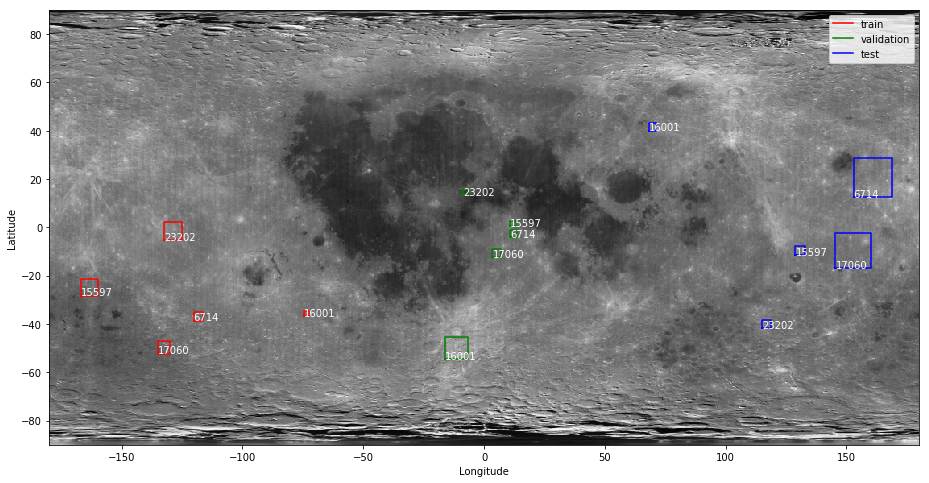

In [37]:
dev_imgs = h5py.File(zenodo_path + '/dev_images.hdf5', 'r')
test_imgs = h5py.File(zenodo_path + '/test_images.hdf5', 'r')

fig = plt.figure(figsize=[16, 8])
al_map = plt.imshow(albedo, extent=[-180, 180, -90, 90], aspect="equal", cmap="Greys_r")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
show_subset = np.random.choice(range(30000),size=5)
for i in show_subset:
  llon,rlon,llat,ulat=train_imgs['longlat_bounds']['img_{:05d}'.format(i)][...]
  h1,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'r')
  plt.text(llon,llat,str(i), color='w')
  
  llon,rlon,llat,ulat=dev_imgs['longlat_bounds']['img_{:05d}'.format(i)][...]
  h2,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'g')
  plt.text(llon,llat,str(i), color='w')
  
  llon,rlon,llat,ulat=test_imgs['longlat_bounds']['img_{:05d}'.format(i)][...]
  h3,=plt.plot([llon, llon, rlon, rlon, llon],[llat, ulat, ulat, llat, llat],'b')
  plt.text(llon,llat,str(i), color='w')
  
  plt.legend((h1,h2,h3),('train','validation','test'))


30.316369107141504


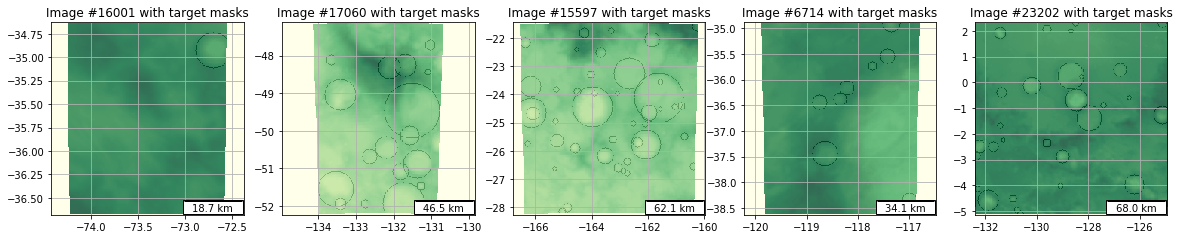

In [39]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
rmoon=1737 #km
kmperdeg = 2*np.pi*rmoon/360
print(kmperdeg)

def plot_map_w_scalebar(ax,train_imgs,im_num):
  im_lims = train_imgs['longlat_bounds']['img_{:05d}'.format(im_num)][...] 
  #streching due to projection: 
#   d=np.diff(im_lims[:2])/np.cos(np.deg2rad(im_lims[2:].mean()))
#   im_lims[0]-=d/2;im_lims[1]+=d/2
  plt.imshow(train_imgs['input_images'][im_num][...], extent=im_lims, origin='upper', 
             cmap='YlGn', aspect='equal') #, vmin=50, vmax=150
  plt.imshow(1-train_imgs['target_masks'][im_num][...], alpha=0.2, extent=im_lims, 
             origin='upper', cmap='Greys_r', aspect='equal')
#   np.cos(np.deg2rad(im_lims[2:].mean()))
  plt.title('Image #{} with target masks'.format(im_num))
  l,r=plt.xlim()
  barlength = 0.3*(r-l)
  bartext = '{:2.1f} km'.format(barlength*kmperdeg)
  bar = AnchoredSizeBar(ax.transData, barlength, bartext, 4)
  ax.add_artist(bar)
  ax.grid()
  return im_lims

fig = plt.figure(figsize=[20, 12])
for i, im_num in enumerate(show_subset):
  ax=plt.subplot(len(show_subset)//5,5,i+1)
  plot_map_w_scalebar(ax,train_imgs,im_num)


## Crater Tables

The ground truth crater data for the images is stored in Pandas HDFStore files `train_craters.hdf5`, `dev_craters.hdf5`, and `test_craters.hdf5` for the training, validation and testing data, respectively.  These tables are used for calculating accuracy metrics when tuning hyperparameters during training.  Let's read in the training ground truth:

In [0]:
ctrs = pd.HDFStore(zenodo_path + '/train_craters.hdf5', 'r')

Like the long/lat boundaries, crater dataframes are indexed by `'img_xxxxx'`, where xxxxx is the zero-padded image number for DEM images from `train_images.hdf5`.  The ground truth for image 3 is:

In [41]:
ctrs['img_02794']

ModuleNotFoundError: ignored

   Diameter (km)        Lat        Long           x           y  Diameter (pix)
0      37.635300 -53.139298 -176.023452  118.447349  247.582379      127.766546
1      17.698620 -52.217700 -174.847562  192.586135  153.153027       60.084323
2       9.156277 -52.191668 -177.003077   56.269286  150.578410       31.084272
3      10.400715 -51.783315 -175.823367  130.922238  107.980928       35.308965
4       8.744995 -51.162220 -174.838797  194.677042   44.511253       29.688026
5       9.456206 -51.054582 -175.366683  160.592888   33.072216       32.102487

Here, "Lat", "Long", and "Diameter (km)" are from the combined LROC-Head crater catalog, while "x", "y" and "Diameter (pix)" were derived from the former columns by the `input_data_gen.py` pipeline.

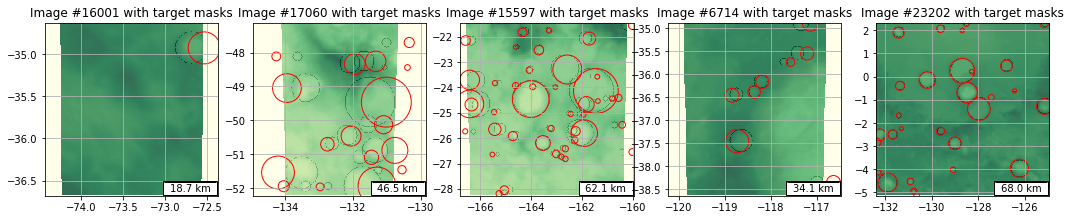

In [42]:
# plot craters from table on map: 
fig = plt.figure(figsize=[18, 9])
for i, im_num in enumerate(show_subset):
  ax=plt.subplot(len(show_subset)//5,5,i+1)
  im_lims=plot_map_w_scalebar(ax,train_imgs,im_num)
#    d=np.diff(im_lims[:2])/np.cos(np.deg2rad(im_lims[2:].mean()))
  for idx,crater in ctrs['img_{:05d}'.format(im_num)].iterrows():
    crater_patch = patches.Circle(np.array([crater['Long'],crater['Lat']]), 
                                   radius = crater['Diameter (km)']/(2*kmperdeg), fill=0, color='r')
    ax.add_artist(crater_patch)
#     print((256-crater['x'])/256)
#     print(crater['Lat'],(im_lims[1]-crater['Long'])/np.diff(im_lims[:2]))

The craters list coordinates seems to be shifted somehow, especially in the higher latitudes. 
This is probably related to projection of the maps. Lets look on the same maps presented without coordinates: 


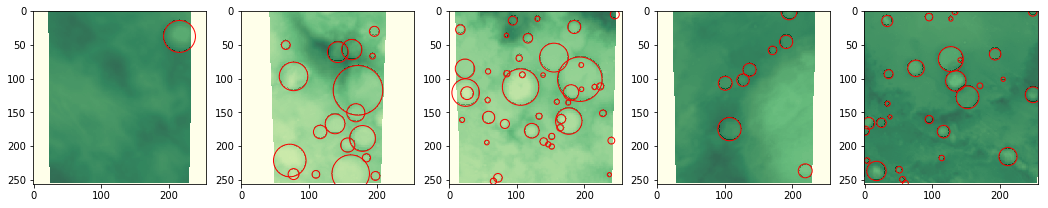

In [43]:
fig = plt.figure(figsize=[18, 9])
for i, im_num in enumerate(show_subset):
  ax2=plt.subplot(len(show_subset)//5,5,i+1)
  plt.imshow(train_imgs['input_images'][im_num][...], origin='upper', cmap='YlGn', aspect='equal') 
  plt.imshow(1-train_imgs['target_masks'][im_num][...], alpha=0.2, origin='upper', cmap='Greys_r')
  for idx,crater in ctrs['img_{:05d}'.format(im_num)].iterrows():
    crater_patch = patches.Circle(np.array([crater['x'],crater['y']]),radius = crater['Diameter (pix)']/(2), fill=0, color='r')
    ax2.add_artist(crater_patch)

It's ok that way. I think the problem is that when i present the maps in their coordinates, its only without the projection. 

# Lunar DEM
LunarLROLrocKaguya_118mperpix.png is the LRO LOLA and Kaguya Terrain Camera DEM Merge, downsampled to 118 m/pixel and 8 bits/pixel. It is combined with the LROC-Head combined crater catalogue by the input_data_gen.py pipeline to create the type of image and ground truth crater datasets we worked with above.

We can create a (tiny) dataset by reading in the DEM and crater catalogues, then passing them the GenDataset function in input_data_gen.py.

In [0]:
# Load input_data_gen
deepmoon_path='/content/DeepMoon/'
# sys.path.append(deepmoon_path)
import input_data_gen as igen
import utils.processing as proc


# Read source image.
img = Image.open(zenodo_path + "/LunarLROLrocKaguya_118mperpix.png").convert("L")
# Read and combine the LROC and Head datasets (stored under ../catalogues)
craters = igen.ReadLROCHeadCombinedCraterCSV(filelroc=deepmoon_path + "/catalogues/LROCCraters.csv",
                                             filehead=deepmoon_path + "/catalogues/HeadCraters.csv")

# Generate 'amt' image/target sets, and corresponding crater dataframes.  np.random.seed is set for consistency.
igen.GenDataset(img, craters, zenodo_path + '/test_zenodo5', amt=25, seed=1337)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (2831155200 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  :param sigma: Standard deviation of noise.


In [0]:
!apt-get -qq install python-cartopy python3-cartopy
import cartopy

In [0]:
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/DeepMoon/']

In [0]:
# craters.iloc[1:5,:]
# pip install pandas==0.22


'/content/DeepMoon/'

This generates test_zenodo_images.hdf5, which stores DEM images, and test_zenodo_craters.hdf5, which stores ground truth crater data. We read in the images and plot one pair:

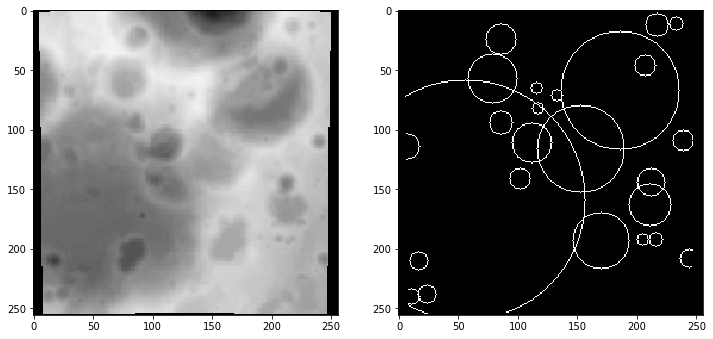

In [0]:
# Read in and pre-process data.
gen_imgs = h5py.File(zenodo_path + '/test_zenodo1_images.hdf5', 'r')
sample_data = {'imgs': [gen_imgs['input_images'][...].astype('float32'),
                        gen_imgs['target_masks'][...].astype('float32')]}
proc.preprocess(sample_data)
sd_input_images = sample_data['imgs'][0]
sd_target_masks = sample_data['imgs'][1]

# Plot the data for fun.
fig = plt.figure(figsize=[12, 6])
[ax1, ax2] = fig.subplots(1,2)
ax1.imshow(sd_input_images[0].squeeze(), origin='upper', cmap='Greys_r', vmin=0, vmax=1.1)
ax2.imshow(sd_target_masks[0].squeeze(), origin='upper', cmap='Greys_r')
plt.show()

Arguments to GenDataset are listed in its docstring. To easily run GenDataset and keep track of your input arguments, see the run_input_data_gen.py script in the repo. This also uses LunarLROLrocKaguya_118mperpix.png (or any other DEM or global map); you'll have to specify its location.

# Generating Predictions From Trained Model Weights
model_keras1.2.2.h5 and model_keras2.h5 are respectively the Keras 1.2.2 and 2.0+ compatible model weights for the trained DeepMoon convolutional neural network (CNN). These can be loaded into memory using Keras's load_model module.

To train a model from scratch, see run_model_train.py.

Note: DeepMoon was train using a 16GB Tesla P100 GPU, and so the model may use prohibitive amounts of memory on systems with less GPU or system RAM.

In [0]:
from keras.models import load_model
sys.path.append("%s/utils/"%deepmoon_path)
import template_match_target as tmt

# Use the commented out line for Keras 2.0+
# model = load_model(zenodo_path + '/model_keras2.h5')
model = load_model(zenodo_path + '/model_keras1.2.2.h5')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
import keras
keras.__version__

'1.2.2'

The model can then be used to predict target masks from input images, and extract crater rings from those predictions. Let's try inserting image 17 from the generated data, and then plotting the predictions and extracted rings against the ground truth target mask.

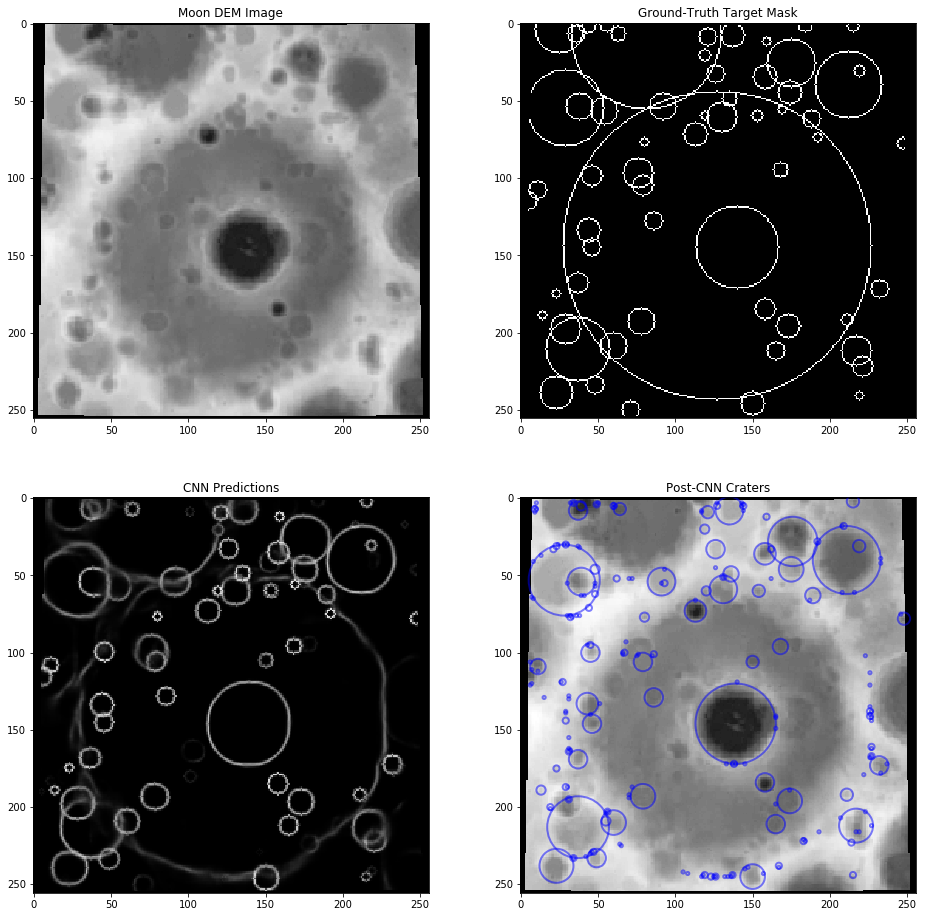

In [0]:
# Use the CNN to make a prediction.  We use [iwant:iwant + 1] to keep input as a 4D tensor.
# Input data MUST BE PREPROCESSED (see proc.preprocess, above) before being passed into model.predict
iwant = 17
pred = model.predict(sd_input_images[iwant:iwant + 1])
# Use scikit-image template matching to extract crater locations.  Only search for craters with r >= 3 pixels.
extracted_rings = tmt.template_match_t(pred[0].copy(), minrad=2.)
#
fig = plt.figure(figsize=[16, 16])
[[ax1, ax2], [ax3, ax4]] = fig.subplots(2, 2)
ax1.imshow(sd_input_images[iwant].squeeze(), origin='upper', cmap='Greys_r', vmin=0, vmax=1.1)
ax2.imshow(sd_target_masks[iwant].squeeze(), origin='upper', cmap='Greys_r')
ax3.imshow(pred[0], origin='upper', cmap='Greys_r', vmin=0, vmax=1)
ax4.imshow(sd_input_images[iwant].squeeze(), origin='upper', cmap="Greys_r")
for x, y, r in extracted_rings:
    circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.5)
    ax4.add_artist(circle)
ax1.set_title('Moon DEM Image')
ax2.set_title('Ground-Truth Target Mask')
ax3.set_title('CNN Predictions')
ax4.set_title('Post-CNN Craters')
plt.show()

As noted from the paper, the trained CNN effectively finds craters with radii  r<15  pixels, but has trouble with larger ones (we did not search for craters with radii  r<3  pixels).

# Post-Processed Craters
post-processed_test_craters.npy contains post-processed craters from the test set (test_images.hdf5) identified by our pipeline. To make it, crater detections were aggregated from all test set DEM images, and their positions and sizes converted to longitude/latitude and kilometres. The dataset was then filtered for duplicates.

Each crater entry is arranged as a tuple: (longitude, latitude, radii), where longitude and latitude are in degrees, and radius is in kilometres.

Here we visualize extracted craters directly onto a Lunar patch using the crop_craters function.

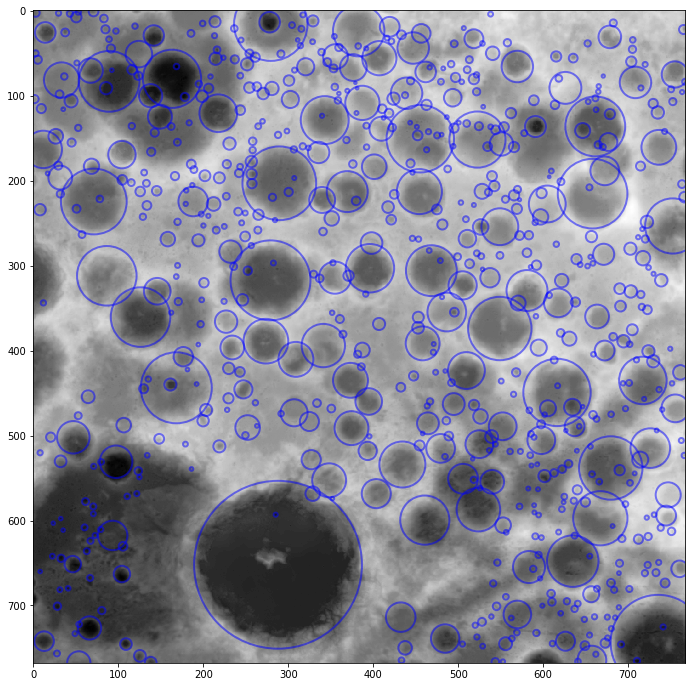

In [0]:
# Load coordinate transforms module from utils.
sys.path.append("%s/utils/"%deepmoon_path)
import transform as tfm

def crop_craters(craters, img_global, xp, yp, lenp):
    """Get desired cropped Lunar region"""
    xc = xp * img_global.size[0] / 3 + 2 * img_global.size[0] / 3
    yc = yp * img_global.size[1]
    rawlen = lenp * img_global.size[0] / 3
    
    box = np.array([xc, yc, xc + rawlen, yc + rawlen], dtype='float32')
    img_crop = img_global.crop(box)
    
    # Crop craters within bounding box, convert to pixel coordinates
    llbd = tfm.pix2coord(box[0::2], box[1::2], [-180., 180., -60., 60.], img_global.size)
    llbd = np.concatenate([llbd[0], llbd[1][::-1]])
    cLo, cLa, cR = craters[(craters.T[0] >= llbd[0]) & (craters.T[0] < llbd[1]) &
                           (craters.T[1] >= llbd[2]) & (craters.T[1] < llbd[3])].T
    x, y = tfm.coord2pix(cLo, cLa, llbd, img_crop.size)
    r = cR / ((llbd[3] - llbd[2]) * (np.pi / 180.0) * (1737.4 / (box[2] - box[0])))
    
    return np.asanyarray(img_crop), np.array(list(zip(x, y, r)))

# Load post-processed craters
craters = np.load(zenodo_path + 'post-processed_test_craters.npy')

# Dimensions of crop
longp = 0.5     # longitude coordinate as a percentage of Lunar test region (0-1 range)
latp = 0.5      # latitude coordinate as a percentage of Lunar test region (0-1 range)
lenp = 0.2      # length of cropped Lunar test region as a percentage  (0-1 range)

# Get cropped image of the Moon and corresponding cropped crater catalogue.
img_lowres = img.resize((int(img.size[0] / 8), int(img.size[1] / 8)))
img_crop, craters_crop = crop_craters(craters, img_lowres, longp, latp, lenp)

# Plot the cropped image alongside the cropped crater catalogue.
f, (ax1) = plt.subplots(1, 1, figsize=[12, 12])
ax1.imshow(img_crop, cmap='Greys_r', vmin=np.min(img_crop), vmax=np.max(img_crop))
for x, y, r in craters_crop:
    circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.5)
    ax1.add_artist(circle)
plt.show()

# Original resolution (60 m/pix) Lunar DEM (SLDEM)


download from: 
http://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/sldem2015/

example tile: 
http://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/sldem2015/tiles/jp2/sldem2015_512_00n_30n_000_045.jp2

label file: 
http://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/sldem2015/tiles/jp2/sldem2015_512_00n_30n_000_045_jp2.lbl

xml file (for gDAL): 
http://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/sldem2015/tiles/jp2/sldem2015_512_00n_30n_000_045_aux.xml

These tiles  (45x30 degrees) are in a compressed format .jp2 and weigh ~180 MB each. Overall 32 tiles x 180 MB = 5.6 GB
The original tiles are in .img format and weight 1.3 GB each, or 42 GB total. 

# KAGUYA DEM (7 m/pix)

https://github.com/fermigas/ltvt/wiki/Obtaining-Kaguya-DEM-data

http://darts.isas.jaxa.jp/planet/pdap/selene/index.html.en

Global coverage of tiles 3x3 degrees. each of size 288 MB in img format. 
Overall 7,200 tile which weigh 1.97 TB
Available here: 
http://darts.isas.jaxa.jp/pub/pds3/sln-l-tc-5-dtm-map-v2.0/ 

example tile: http://darts.isas.jaxa.jp/pub/pds3/sln-l-tc-5-dtm-map-v2.0/lon000/data/DTM_MAP_02_N00E000S03E003SC.img

label file: http://darts.isas.jaxa.jp/pub/pds3/sln-l-tc-5-dtm-map-v2.0/lon000/data/DTM_MAP_02_N00E000S03E003SC.lbl 


# LROC DEM (5-2 m/pix)

463 regional data products in changing size. mostly about 0.5 deg longitude on 2 deg latitude

search engine: 
http://wms.lroc.asu.edu/lroc/rdr_product_select?filter%5Btext%5D=&filter%5Blat%5D=&filter%5Blon%5D=&filter%5Brad%5D=&filter%5Bwest%5D=&filter%5Beast%5D=&filter%5Bsouth%5D=&filter%5Bnorth%5D=&filter%5Btopographic%5D=true&filter%5Bgroup_type%5D%5B%5D=Regional+Product&filter%5Bprefix%5D%5B%5D=NAC_DTM&show_thumbs=0&per_page=10&commit=Search

heres the directory: 
http://lroc.sese.asu.edu/data/


example for one: 
http://lroc.sese.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/DATA/SDP/NAC_DTM/AESTUUM2/NAC_DTM_AESTUUM2.TIF
label file: 
http://lroc.sese.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/DATA/SDP/NAC_DTM/AESTUUM2/NAC_DTM_AESTUUM2.LBL
